<a href="https://colab.research.google.com/github/duneag2/intro-dl/blob/main/DLMATHon/uh/dlmathon1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
! unzip -qq '/content/drive/MyDrive/2021-data-creator-camp-1120-1' -d '/content/drive/MyDrive'

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/kfood/

/content/drive/MyDrive/kfood


In [13]:
!ls

test  train  val


In [3]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.3.1+cu121  Device: cpu


In [6]:
train_dir = '/content/drive/MyDrive/kfood/train'
val_dir = '/content/drive/MyDrive/kfood/val'
test_dir = '/content/drive/MyDrive/kfood/test'

In [7]:
# Data augmentation and normalization for training# Just normalization for validation and test
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [8]:
for phase in ['train', 'val']:
    phase_dir = os.path.join('/content/drive/MyDrive/kfood', phase)
    for class_dir in os.listdir(phase_dir):
        class_path = os.path.join(phase_dir, class_dir)
        images = os.listdir(class_path)
        print(f'{class_dir} 폴더에는 {len(images)}개의 이미지가 있습니다.')

BoiledDown 폴더에는 597개의 이미지가 있습니다.
Kimchi 폴더에는 596개의 이미지가 있습니다.
Noodle 폴더에는 766개의 이미지가 있습니다.
Rice 폴더에는 766개의 이미지가 있습니다.
Roasted 폴더에는 766개의 이미지가 있습니다.
BoiledDown 폴더에는 117개의 이미지가 있습니다.
Kimchi 폴더에는 117개의 이미지가 있습니다.
Noodle 폴더에는 150개의 이미지가 있습니다.
Rice 폴더에는 150개의 이미지가 있습니다.
Roasted 폴더에는 150개의 이미지가 있습니다.


In [9]:
# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}


In [10]:
# Create the dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
# Get the class names
class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer to match the number of classes in our dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU if available
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


In [12]:
def initialize_model(num_classes, learning_rate, momentum, weight_decay=1e-4):
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    # L2 Regularization (Weight Decay)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # 학습률 스케줄러 추가 (여기서는 감소시키는 스케줄러 사용)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    criterion = nn.CrossEntropyLoss()

    return model, criterion, optimizer, exp_lr_scheduler

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    print('Training complete')


In [13]:
# 예시: 다양한 hyperparameter 설정을 사용하여 모델 훈련
learning_rate = 0.001
momentum = 0.9
weight_decay = 1e-4  # L2 regularization 파라미터

In [14]:
model, criterion, optimizer, scheduler = initialize_model(num_classes, learning_rate, momentum, weight_decay)

In [ ]:
# Train the model
train_model(model, criterion, optimizer, scheduler, num_epochs=25)


# Save the trained model
def save_model(model, file_path):
    # 기존 파일이 존재하는지 확인하고, 존재하면 삭제합니다.
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Existing file '{file_path}' has been deleted.")

    # 모델 저장
    torch.save(model.state_dict(), file_path)
    print(f"Model has been saved to '{file_path}'.")

# 모델, criterion, optimizer, scheduler 초기화
model, criterion, optimizer, scheduler = initialize_model(num_classes, learning_rate, momentum, weight_decay)

# 모델 훈련
train_model(model, criterion, optimizer, scheduler, num_epochs=25)

# 모델 파일 경로 설정
model_path = '/content/drive/MyDrive/kfood/resnet50_kfood.pth'

# 모델 저장
save_model(model, model_path)


Epoch 1/25
----------


In [ ]:
def test_model(model, dataloaders):
    model.eval()  # 모델을 평가 모드로 설정
    corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

            # 실제 레이블과 예측 레이블 출력
            print("Actual labels:", labels.data)
            print("Predicted labels:", preds)

    accuracy = corrects.double() / len(image_datasets['test'])
    print(f'Test Accuracy: {accuracy:.4f}')

In [ ]:
# Test the model
test_model(model, dataloaders)

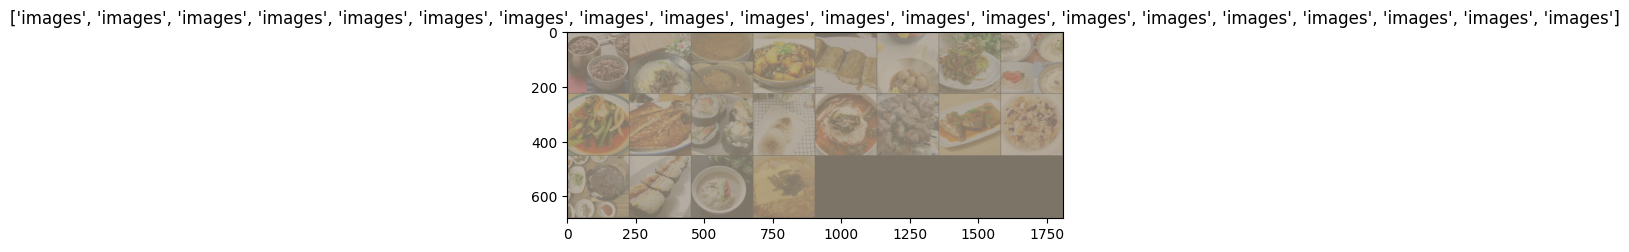

In [60]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# 데이터셋 로드
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader 생성
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)

# 텐서를 이미지로 변환하는 함수
def imshow(inp, title=None):
    """텐서를 이미지로 보여주는 함수."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 그래프가 업데이트되는 동안 잠시 대기

# 테스트 데이터에서 배치 가져오기
inputs, classes = next(iter(test_loader))

# 배치에서 그리드 만들기
out = torchvision.utils.make_grid(inputs)

# 클래스 이름 가져오기
class_names = test_dataset.classes
imshow(out, title=[class_names[x] for x in classes])